In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install object-detection-fastai

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
from tqdm.notebook import tqdm
from xml.etree.ElementTree import parse
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as immg
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold,KFold

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [ ]:
#path = '../input/hard-hat-detection/annotations'
#path_img = '../input/hard-hat-detection/images'

path = '/content/drive/My Drive/safety helmet detection/annotations'
path_img = '/content/drive/My Drive/safety helmet detection/images'

In [ ]:
file_xml = []
for file in os.listdir(path):
    if '.xml' in file:
        file_xml.append(file)

## Processing xml files :
* For **BBOXs** and **Labels**

In [ ]:
hat = []
labels = []
object_xmin=[]
object_ymin=[]
object_xmax=[]
object_ymax=[]
for i in tqdm(range(len(file_xml))):
    name = file_xml[i]
    hat.append(name[:-4])
    objects = parse(os.path.join(path,file_xml[i])).findall('object')
    object_xmin.append([int(x.find("bndbox").findtext("xmin")) for x in objects])
    object_ymin.append([int(x.find("bndbox").findtext("ymin")) for x in objects])
    object_xmax.append([int(x.find("bndbox").findtext("xmax")) for x in objects])
    object_ymax.append([int(x.find("bndbox").findtext("ymax")) for x in objects])
    labels.append([x.findtext('name') for x in objects])

In [ ]:
df = pd.DataFrame({'file_name':hat,'xmin':object_xmin,'ymin':object_ymin,
                                   'xmax':object_xmax,'ymax':object_ymax,'labels':labels})

In [ ]:
#path1 = Path('../input/hard-hat-detection')
path1 = Path('/content/drive/My Drive/safety helmet detection')

## Function to get BBOXs

In [ ]:
def image_lbl(df):
    hat2bbox = {}
    for i in tqdm(range(df.shape[0])):
        bbox = []
        lbl =[]
        title = []
        a = df.iloc[i][1:-1].values
        l = df.iloc[i][-1]
        for j in range(len(l)):
            bbx = [x[j] for x in a]
            if l[j]!='person':
                bbx = [bbx[1],bbx[0],bbx[3],bbx[2]]
                lbl.append(bbx)
                title.append(l[j])
        bbox.append(lbl)
        bbox.append(title)
        hat2bbox[df.iloc[i][0]+'.png'] = bbox
    return hat2bbox

In [ ]:
hat2bbox = image_lbl(df)

## Sample Image

In [ ]:
def show_sam(n):
    name = df.iloc[n][0] + '.png'
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(immg.imread(os.path.join(path_img,name)))
    B = hat2bbox[name]
    for l,bbox in zip(B[1],B[0]):
        bbox = [bbox[1],bbox[0],bbox[3],bbox[2]]
        bbox[2] = abs(bbox[0]-bbox[2])
        bbox[3] = abs(bbox[1]-bbox[3])
        draw_rect(ax,bbox,text=l)
    plt.axis('off')

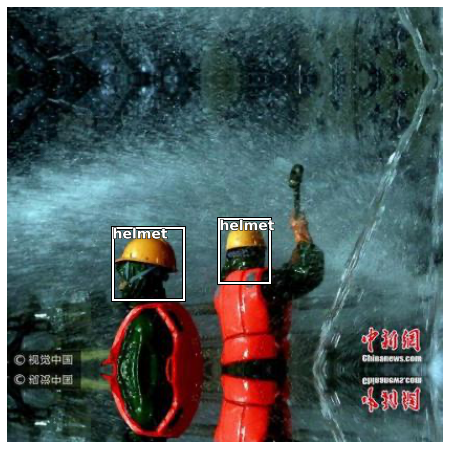

In [ ]:
show_sam(random.randint(2,4800))

### Function to get bbox for each image

In [ ]:
get_y_func = lambda o: hat2bbox[Path(o).name] 

In [ ]:
tfms = get_transforms()
size = 512

## DataBunch

In [ ]:
data = (ObjectItemList.from_df(df,path1, folder = 'images' , suffix = '.png',cols='file_name')
        #Where are the images? ->
        .split_by_rand_pct(0.2)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(size=size,tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=8, collate_fn=bb_pad_collate))  

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/fastai/vision/data.py:361: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  if len((labels - self.pad_idx).nonzero()) == 0: return


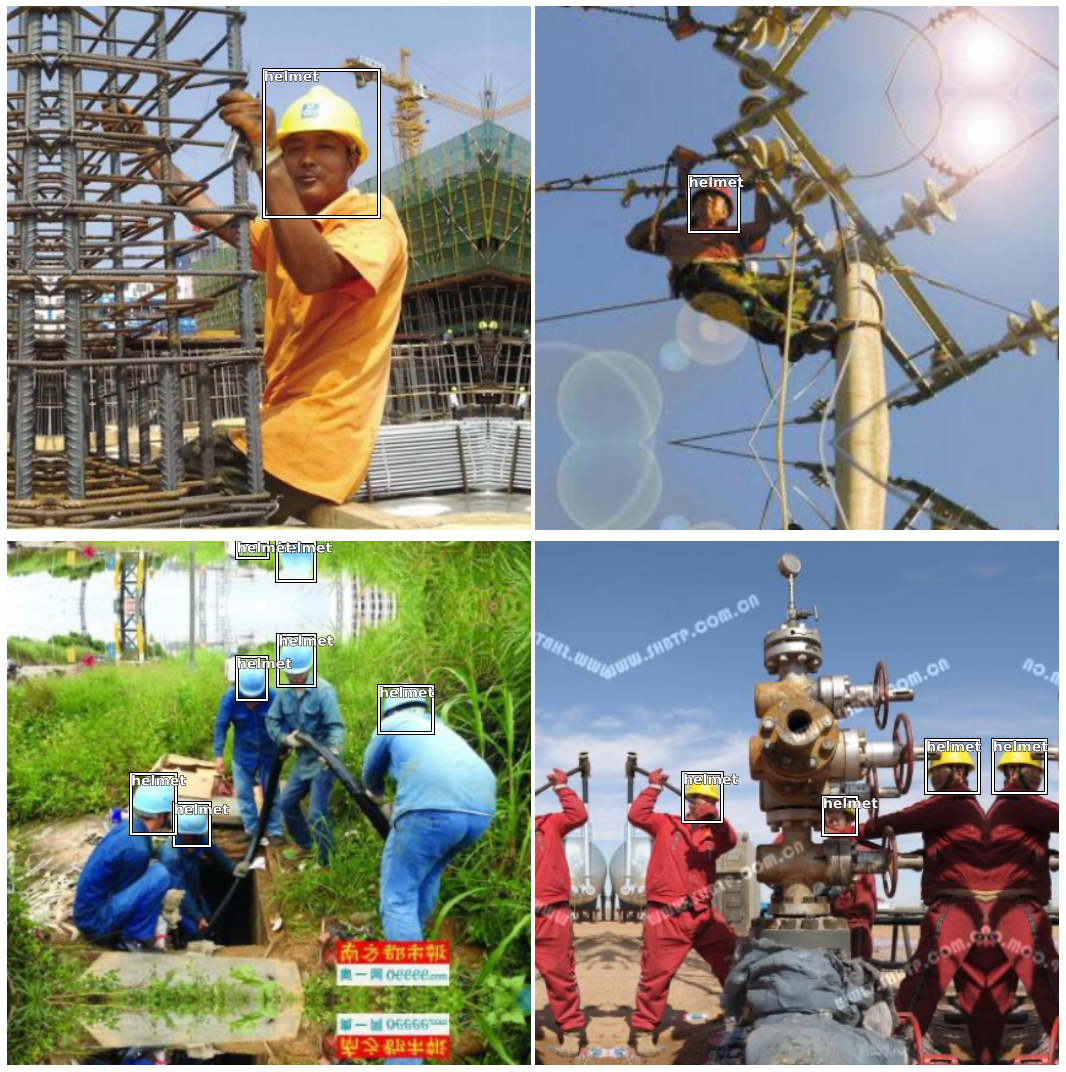

In [ ]:
data.show_batch(rows=2,  figsize=(15,15))

In [ ]:
len(data.train_ds),len(data.valid_ds),data.classes

(4000, 1000, ['background', 'head', 'helmet'])

In [ ]:
print(data)

ImageDataBunch;

Train: LabelList (4000 items)
x: ObjectItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ObjectCategoryList
ImageBBox (512, 512),ImageBBox (512, 512),ImageBBox (512, 512),ImageBBox (512, 512),ImageBBox (512, 512)
Path: /content/drive/My Drive/safety helmet detection;

Valid: LabelList (1000 items)
x: ObjectItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ObjectCategoryList
ImageBBox (512, 512),ImageBBox (512, 512),ImageBBox (512, 512),ImageBBox (512, 512),ImageBBox (512, 512)
Path: /content/drive/My Drive/safety helmet detection;

Test: None


In [ ]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.3, 0.6, 1.2, 2, 2.8, 3.4,])
#anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.4, 0.6, 0.85, 1, 1.6, 1.8])

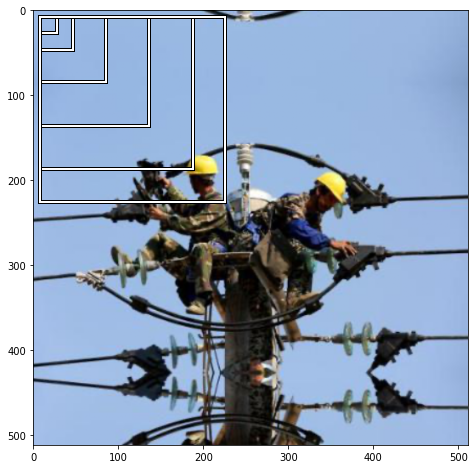

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:6]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [ ]:
print(anchors)

tensor([[-0.9688, -0.9688,  0.0750,  0.0750],
        [-0.9688, -0.9688,  0.1500,  0.1500],
        [-0.9688, -0.9688,  0.3000,  0.3000],
        ...,
        [ 0.9688,  0.9688,  0.5000,  0.5000],
        [ 0.9688,  0.9688,  0.7000,  0.7000],
        [ 0.9688,  0.9688,  0.8500,  0.8500]])


In [ ]:
len(anchors)

6144

In [ ]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=6, sizes=[32], chs=32, final_bias=-4., n_conv=3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, 
                loss_func=crit, 
                callback_fns=[BBMetrics],
                metrics=[voc],
               model_dir='/content/drive/My Drive/safety helmet detection')

In [ ]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


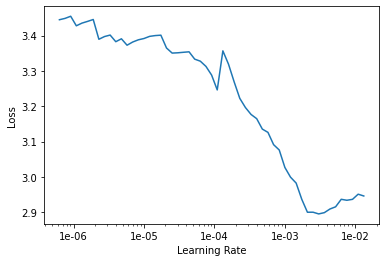

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
gc.collect()

6288

In [ ]:
learn.fit_one_cycle(3, 1e-3 , callbacks = [ SaveModelCallback(learn, every ='improvement', monitor = 'AP-helmet', name = 'Best_model' ) ] )

Better model found at epoch 0 with AP-helmet value: 0.6262757552257228.
Better model found at epoch 1 with AP-helmet value: 0.6318561291950655.
Better model found at epoch 2 with AP-helmet value: 0.6787508956483541.


In [ ]:
learn.load('Best_model');
learn.export('/content/drive/My Drive/safety helmet detection/SafetyHelmet.pkl');

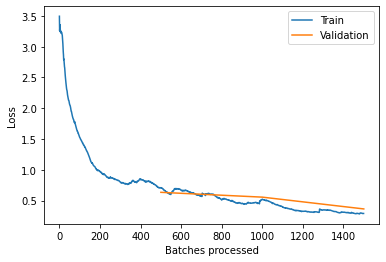

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, callbacks = [SaveModelCallback(learn, every ='improvement', monitor ='AP-helmet', name ='Best_model_ft')] )

Better model found at epoch 0 with AP-helmet value: 0.6726502310766437.
Better model found at epoch 7 with AP-helmet value: 0.6957517377524739.


In [ ]:
learn.load('Best_model_ft');
learn.export('/content/drive/My Drive/safety helmet detection/SafetyHelmet_ft.pkl');

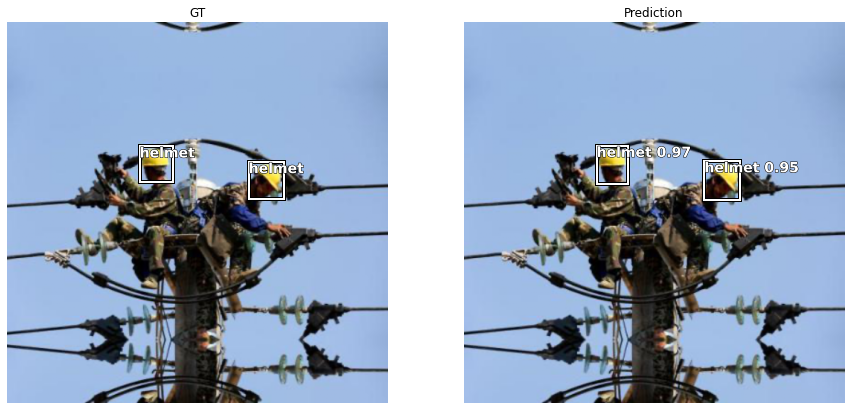

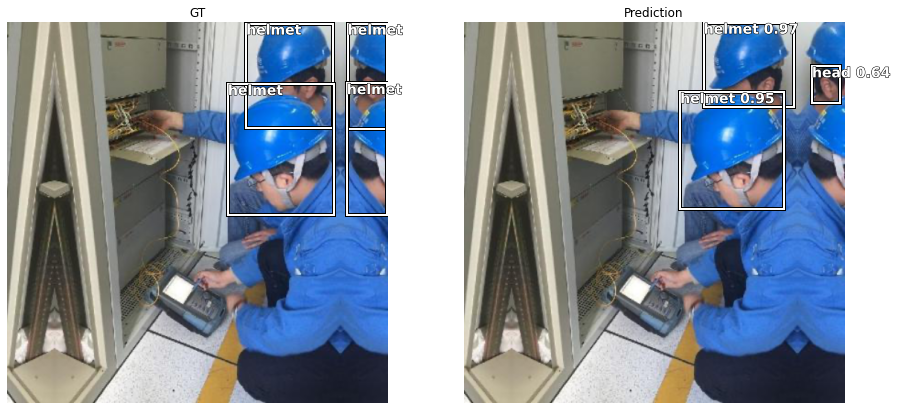

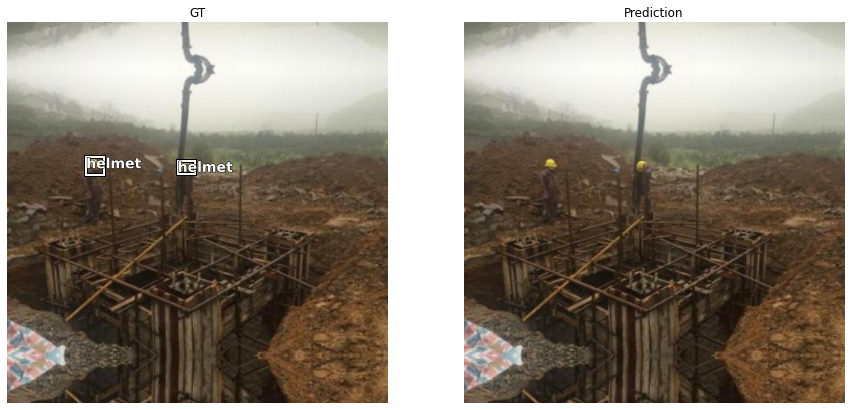

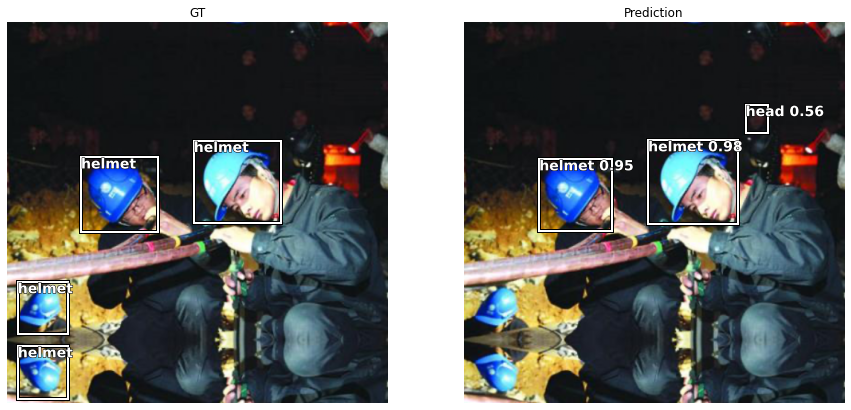

In [ ]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=4)